In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('../CleaningTableFlights/data/model_df_version_2.csv')
dep_delay = pd.read_csv('../CleaningTableFlights/data/flights.csv')[['dep_delay','origin']]

In [4]:
df = df.drop(columns='cancelled_flights')

In [5]:
dep_delay = dep_delay.groupby('origin').mean()
dep_delay = dep_delay.rename({'dep_delay':'average_departure_delay_by_ap'},axis=1)

In [6]:
arr_delay = df[['dest','arr_delay']]
arr_delay = arr_delay.groupby('dest').mean()
arr_delay = arr_delay.rename({'arr_delay':'average_arrival_delay_by_ap'},axis=1)

In [7]:
arr_delay

,average_arrival_delay_by_ap
dest,
ABE,21.464286
ABI,6.235294
ABQ,4.498246
ABR,47.000000
ABY,34.187500
...,...
XNA,5.148515
XWA,6.500000
YAK,-1.533333


In [8]:
df = df.drop(['tail_num','mkt_carrier_fl_num'], axis = 1)

In [9]:
pass_fuel_df = pd.read_csv('data/passenger_fuel_df_full.csv')

In [10]:
departures_df = pd.read_csv('data/departures_by_airport_full.csv')
departures_df = departures_df.drop('origin_city_name',axis=1)

In [11]:
arrivals_df = pd.read_csv('data/arrivals_by_airport_full.csv')
arrivals_df = arrivals_df.drop('dest_city_name',axis=1)

In [12]:
df['month'] = pd.DatetimeIndex(df['fl_date']).month
df['weekday'] = pd.DatetimeIndex(df['fl_date']).weekday

In [13]:
df = df.drop(['fl_date'],axis=1)

In [14]:
df['crs_arr_time'] = (df['crs_arr_time']//100)*60 + df['crs_arr_time'] - (df['crs_arr_time']//100)*100
df['crs_dep_time'] = (df['crs_dep_time']//100)*60 + df['crs_dep_time'] - (df['crs_dep_time']//100)*100

In [15]:
df.head()

,mkt_unique_carrier,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday
0,DL,DL,GSP,ATL,620,686,66.0,153,-5.0,2,1
1,AS,AS,LAX,SJC,1205,1290,85.0,308,53.0,5,5
2,DL,DL,JAX,ATL,940,1018,78.0,270,-13.0,1,1
3,UA,ZW,IAD,ALB,1035,1134,99.0,325,-33.0,11,6
4,AA,AA,CLT,DCA,790,877,87.0,331,-12.0,7,1


In [16]:
pass_fuel_df.head(5)

,mkt_unique_carrier,avg_distance_per_month_by_carrier,avg_dep_delay_by_carrier,total_gallons,passengers_by_carrier_per_month,monthly_distance_per_passenger,avgfuel_percustomer_perdistance
0,AA,1.198062e+08,1.732355e+06,529073.835069,1.269777e+07,0.105986,4.991926e+06
1,AS,3.493391e+07,1.290336e+05,121682.671875,2.920384e+06,0.083597,1.455580e+06
2,B6,2.733835e+07,4.146305e+05,147726.593750,3.545438e+06,0.129687,1.139098e+06
3,DL,1.014802e+08,1.347398e+06,547151.206597,1.313163e+07,0.129401,4.228340e+06
4,F9,1.099285e+07,1.775858e+05,74017.159722,1.776412e+06,0.161597,4.580353e+05


In [17]:
departures_df.head()

,origin,yearly_departures_per_ap,yearly_passengers_per_ap
0,05A,75.4,149.6
1,06A,7.2,3.8
2,08A,2.0,3.0
3,09A,7.2,8.6
4,1B1,1.8,5.8


In [18]:
arrivals_df.head()

,dest,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap
0,05A,76.6,168.6
1,06A,7.0,3.6
2,08A,2.2,3.4
3,09A,7.4,13.0
4,1B1,1.2,3.2


In [19]:
#dropping variables that weren't significant off the bat (high multicollinearity)
pass_fuel_df = pass_fuel_df.drop(columns=['avg_distance_per_month_by_carrier','total_gallons','passengers_by_carrier_per_month','monthly_distance_per_passenger'])

In [20]:
#add in fuel and passenger info by carrier
df = df.merge(pass_fuel_df, how = 'left', left_on='mkt_unique_carrier',right_on='mkt_unique_carrier')

In [21]:
#add in departure and passenger info by airport
df = df.merge(departures_df, how = 'left', on = 'origin')

#add in arrival and passenger info by arrival airport
df = df.merge(arrivals_df, how = 'left', on = 'dest')

#add in average departure delay by departure location
df = df.merge(dep_delay, how = 'left', left_on = 'origin', right_index = True)

#add in average arrival delay by arrival location
df = df.merge(arr_delay, how = 'left', left_on = 'origin', right_index = True)

In [22]:
#add constant
df['constant'] = 1
first_column = df.pop('constant')
df.insert(0, 'constant', first_column)

In [23]:
df.head()

,constant,mkt_unique_carrier,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap,average_departure_delay_by_ap,average_arrival_delay_by_ap
0,1,DL,DL,GSP,ATL,620,686,66.0,153,-5.0,2,1,1.347398e+06,4.228340e+06,17174.4,1092760.2,435839.8,51557297.6,12.627358,5.990741
1,1,AS,AS,LAX,SJC,1205,1290,85.0,308,53.0,5,5,1.290336e+05,1.455580e+06,326591.6,41149051.0,60583.2,6336858.6,8.952404,2.577270
2,1,DL,DL,JAX,ATL,940,1018,78.0,270,-13.0,1,1,1.347398e+06,4.228340e+06,33446.4,2985380.0,435839.8,51557297.6,6.891824,7.073282
3,1,UA,ZW,IAD,ALB,1035,1134,99.0,325,-33.0,11,6,1.625398e+06,4.223693e+06,115492.8,11166124.4,20357.4,1403378.0,11.155459,8.177550
4,1,AA,AA,CLT,DCA,790,877,87.0,331,-12.0,7,1,1.732355e+06,4.991926e+06,257268.0,22567735.0,143488.4,11486941.8,11.424054,2.172201


In [25]:
#create variable where 1 if op_carrier different from mkt_carrier
df['op_unique_carrier_check'] = df['op_unique_carrier'] != df['mkt_unique_carrier']
df['op_unique_carrier_check'] = df['op_unique_carrier_check'].astype('int')

In [26]:
df.corr()

C:\Users\Andrew\AppData\Local\Temp\ipykernel_18984\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,constant,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap,average_departure_delay_by_ap,average_arrival_delay_by_ap,op_unique_carrier_check
constant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crs_dep_time,NaN,1.000000,0.701127,-0.017543,-0.009546,0.090224,0.001285,0.007812,-0.013043,-0.012102,0.136161,0.135331,-0.146264,-0.136561,0.010863,-0.035263,-0.006547
crs_arr_time,NaN,0.701127,1.000000,0.018933,0.013365,0.077562,-0.002177,0.007310,0.010385,0.013107,0.112040,0.104379,-0.109756,-0.103442,0.030829,-0.006415,0.001135
crs_elapsed_time,NaN,-0.017543,0.018933,1.000000,0.982468,-0.014231,-0.007333,0.014031,-0.117374,-0.126366,0.107401,0.136953,0.152202,0.184051,0.055298,0.031736,-0.356415
distance,NaN,-0.009546,0.013365,0.982468,1.000000,-0.014252,-0.000571,0.016040,-0.147289,-0.157149,0.106935,0.142978,0.111119,0.146271,0.008482,-0.015803,-0.399282
arr_delay,NaN,0.090224,0.077562,-0.014231,-0.014252,1.000000,-0.008594,-0.008843,0.016054,0.003723,0.018266,0.012408,0.003789,-0.000115,0.042969,0.032439,0.029291
month,NaN,0.001285,-0.002177,-0.007333,-0.000571,-0.008594,1.000000,0.012941,0.002453,0.003325,-0.001918,-0.003294,0.005086,0.003584,-0.004124,-0.000739,0.002220
weekday,NaN,0.007812,0.007310,0.014031,0.016040,-0.008843,0.012941,1.000000,-0.011483,-0.014187,-0.001876,-0.001196,-0.004968,-0.003839,0.003754,0.002254,-0.000921
avg_dep_delay_by_carrier,NaN,-0.013043,0.010385,-0.117374,-0.147289,0.016054,0.002453,-0.011483,1.000000,0.973563,0.145485,0.091820,0.139442,0.084745,0.208247,0.133946,0.318460
avgfuel_percustomer_perdistance,NaN,-0.012102,0.013107,-0.126366,-0.157149,0.003723,0.003325,-0.014187,0.973563,1.000000,0.145830,0.096309,0.141823,0.091129,0.159243,0.081730,0.324518


In [126]:
#fill arrival/departure average nans with 0
df = df.fillna(0)

In [127]:
df_new_model = df.drop(['origin','dest','op_unique_carrier'],axis=1)
df = df.drop(['op_unique_carrier'],axis=1)

In [128]:
original_dummy_df =  pd.get_dummies(df,columns=['mkt_unique_carrier','month','weekday','origin','dest'])
dummy_df = pd.get_dummies(df_new_model,columns=['mkt_unique_carrier','month','weekday'])

In [129]:
dummy_df.head()

,constant,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,620,686,66.0,153,-5.0,13638.541667,4.845182e+08,17174.4,1092760.2,...,0,0,0,0,1,0,0,0,0,0
1,1,1205,1290,85.0,308,53.0,1179.083333,1.532321e+08,326591.6,41149051.0,...,0,0,0,0,0,0,0,0,1,0
2,1,940,1018,78.0,270,-13.0,13638.541667,4.845182e+08,33446.4,2985380.0,...,0,0,0,0,1,0,0,0,0,0
3,1,1035,1134,99.0,325,-33.0,17035.250000,6.405021e+08,115492.8,11166124.4,...,0,1,0,0,0,0,0,0,0,1
4,1,790,877,87.0,331,-12.0,17462.958333,5.888144e+08,257268.0,22567735.0,...,0,0,0,0,1,0,0,0,0,0


This is based on ALL variables without removing anything by op_carrier

In [130]:
X_original = original_dummy_df.drop('arr_delay',axis=1)
y_original = original_dummy_df['arr_delay']

In [131]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original,y_original,test_size = .2)

In [132]:
X_train_original

,constant,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,...,dest_VEL,dest_VLD,dest_VPS,dest_WRG,dest_WYS,dest_XNA,dest_XWA,dest_YAK,dest_YKM,dest_YUM
29344,1,460,611,151.0,970,920.708333,2.039733e+07,7259.8,1006275.2,7390.0,...,0,0,0,0,0,0,0,0,0,0
97843,1,933,1090,157.0,836,17035.250000,6.405021e+08,433377.0,38803817.4,56119.6,...,0,0,0,0,0,0,0,0,0,0
152081,1,1289,1437,148.0,762,17462.958333,5.888144e+08,178535.6,14846194.0,435839.8,...,0,0,0,0,0,0,0,0,0,0
153231,1,530,693,163.0,919,1537.250000,4.565665e+07,114925.2,12992428.4,35244.4,...,0,0,0,0,0,0,0,0,0,0
93914,1,735,1100,245.0,1744,17035.250000,6.405021e+08,326591.6,41149051.0,432876.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20327,1,720,862,262.0,1744,17462.958333,5.888144e+08,433377.0,38803817.4,325699.2,...,0,0,0,0,0,0,0,0,0,0
84083,1,1155,1178,83.0,240,17462.958333,5.888144e+08,17659.8,943307.0,432876.6,...,0,0,0,0,0,0,0,0,0,0
106967,1,1079,1204,185.0,963,17462.958333,5.888144e+08,178535.6,14846194.0,95837.4,...,0,0,0,0,0,0,0,0,0,0
36809,1,360,681,201.0,1541,13638.541667,4.845182e+08,19812.0,1699691.0,435839.8,...,0,0,0,0,0,0,0,0,0,0


In [133]:
print(X_train_original.shape,X_test_original.shape,y_train_original.shape,y_test_original.shape)

(127035, 785) (31759, 785) (127035,) (31759,)


In [134]:
lin_reg_original = sm.OLS(y_train_original,X_train_original)

In [135]:
original_model = lin_reg_original.fit()

print(original_model.summary())

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.259
Date:                Fri, 19 May 2023   Prob (F-statistic):               0.00
Time:                        12:52:16   Log-Likelihood:            -6.7465e+05
No. Observations:              127035   AIC:                         1.351e+06
Df Residuals:                  126263   BIC:                         1.358e+06
Df Model:                         771                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

Everything below this is run on test variables

In [136]:
#drop final category of each dummy variable
dummy_df = dummy_df.drop(columns=['month_12','weekday_6','mkt_unique_carrier_WN'])

In [137]:
X = dummy_df.drop('arr_delay',axis=1)
y = dummy_df['arr_delay']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2)

In [139]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(127035, 41) (31759, 41) (127035,) (31759,)


In [140]:
lin_reg = sm.OLS(y_train,X_train)

In [141]:
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     64.61
Date:                Fri, 19 May 2023   Prob (F-statistic):               0.00
Time:                        12:52:17   Log-Likelihood:            -6.7558e+05
No. Observations:              127035   AIC:                         1.351e+06
Df Residuals:                  126996   BIC:                         1.352e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

In [142]:
model.pvalues.index

Index(['constant', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'distance', 'avg_dep_delay_by_carrier',
       'avgfuel_percustomer_perdistance', 'yearly_departures_per_ap',
       'yearly_passengers_per_ap', 'yearly_arrivals_per_ap',
       'yearly_arriving_passengers_per_ap', 'average_departure_delay_by_ap',
       'average_arrival_delay_by_ap', 'op_unique_carrier_check',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5'],
      dtype='object')

In [143]:
X_new = X_train.copy()

In [144]:
def backwards_stepwise_regression(model,X,y,alpha):
    dropped_cols=[]
    X_new = X.copy()
    #for each original variable in X, fit model
    for var in range(len(X)):
        lin_reg = sm.OLS(y,X_new)
        model = lin_reg.fit()
         #for each column in X_new, search the p values for the largest one
        pvals=[]
        max_pval = 0
        for i in range(len(X_new.columns)):
            #check each pvalue
            pval = model.pvalues[i]
            pvals.append(pval)
            max_pval = max(pvals)
            if pval == max_pval:
                max_p = i
        #if p > alpha drop column and append to table
        if max_pval > alpha:
            col = X_new.columns[max_p]                              
            X_new = X_new.drop(columns=col)
            dropped_cols.append(col)
            print('Model #:'+str(var)+', Removed variable: '+str(col))
        #else if all above alpha, end and print statistics
        else:
            print_model = model.summary()
            print(print_model)
            return dropped_cols

In [145]:
backwards_stepwise_regression(model,X_train,y_train,.05)

Model #:0, Removed variable: month_5
Model #:1, Removed variable: weekday_1
Model #:2, Removed variable: weekday_2
Model #:3, Removed variable: mkt_unique_carrier_HA
Model #:4, Removed variable: mkt_unique_carrier_VX
Model #:5, Removed variable: mkt_unique_carrier_AA
Model #:6, Removed variable: avgfuel_percustomer_perdistance
Model #:7, Removed variable: month_2
                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     76.47
Date:                Fri, 19 May 2023   Prob (F-statistic):               0.00
Time:                        12:52:19   Log-Likelihood:            -6.7558e+05
No. Observations:              127035   AIC:                         1.351e+06
Df Residuals:                  127002   BIC:                         1.352e+06
Df

['month_5',
 'weekday_1',
 'weekday_2',
 'mkt_unique_carrier_HA',
 'mkt_unique_carrier_VX',
 'mkt_unique_carrier_AA',
 'avgfuel_percustomer_perdistance',
 'month_2']

In [146]:
y_pred = model.predict(X_test)

In [147]:
y_pred

71032      6.352670
51193      5.334484
44657     -1.699368
9321       3.123795
114215    18.652579
            ...    
45427      5.690665
8359      17.517233
57672      8.075768
59024     10.531446
95407      5.186860
Length: 31759, dtype: float64

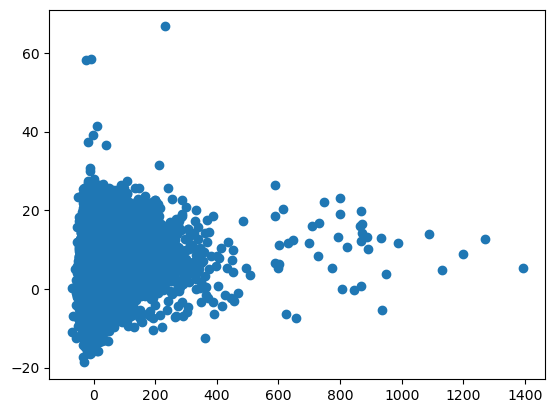

In [148]:
plt.scatter(y_test,y_pred)

In [149]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 2471.71
RMSE: 49.72


In [150]:
r2_score(y_test,y_pred)

0.019006333980258305